In [3]:
using Statistics
using DelimitedFiles
using Dates
using Flux
using MLDataUtils
using Random
using LinearAlgebra
using StatsBase
using Flux: onehotbatch, onecold, crossentropy, DataLoader
using Statistics
using Plots
using CSV
using DataFrames

In [4]:
# Probability function
function PSPACS(n, nbar, Ploss)
    if n == 0
        return 0
    elseif n == 1
        return ((exp(-nbar) / (1 + nbar)) * ((nbar ^ (n-1) / factorial(n - 1)) + (nbar * (nbar ^ (n - 2) / Inf)))) * (1 - Ploss)^nbar
    else
        return ((exp(-nbar) / (1 + nbar)) * ((nbar ^ (n-1) / factorial(n - 1)) + (nbar * (nbar ^ (n - 2) / factorial(n - 2))))) * (1 - Ploss)^nbar
    end
end

function PSPATS(n, nbar, Ploss)
    if n == 0
        return 0
    else
        return ((nbar ^ (n - 1) / (1 + nbar) ^ (n + 1)) * binomial(n, 1)) * (1 - Ploss)^nbar
    end
end

function dataGen(source, nbar, NExperiment, Ploss)
    # Zeros  = round(Int, NExperiment * source(0, nbar))
    Ones   = round(Int, NExperiment * source(1, nbar, Ploss))
    Twos   = round(Int, NExperiment * source(2, nbar, Ploss))
    Threes = round(Int, NExperiment * source(3, nbar, Ploss))
    Fours  = round(Int, NExperiment * source(4, nbar, Ploss))
    Fives  = round(Int, NExperiment * source(5, nbar, Ploss))
    Sixes  = round(Int, NExperiment * source(6, nbar, Ploss))

    data = []
    photonCounts = [Ones, Twos, Threes, Fours, Fives, Sixes]
    for i in 1:6
        photons =  zeros(photonCounts[i]) .+ (i)
        data = vcat(data, photons)
    end

    shuffle!(data)

    return data
end

function getProbs(data)
    return [count(x -> x == i, data) / size(data, 1) for i in 1:6]
end

function preprocess(spacs, spats, split)
    spacs = hcat(spacs, zeros(size(spacs, 1)))
    trainSpacs, testSpacs = spacs[1:Int(round(size(spacs, 1)*split)), :], spacs[Int(round(size(spacs, 1)*split))+1:end, :]
    spats = hcat(spats, ones(size(spats, 1)))
    trainSpats, testSpats = spats[1:Int(round(size(spats, 1)*split)), :], spats[Int(round(size(spats, 1)*split))+1:end, :]
    trainData = vcat(trainSpacs, trainSpats)
    testData = vcat(testSpacs, testSpats)
    trainData = trainData[shuffle(1:size(trainData, 1)), :]
    testData = testData[shuffle(1:size(testData, 1)), :]
    trainX, trainY, testX, testY = trainData[:, 1:end-1], trainData[:, end], testData[:, 1:end-1], testData[:, end]
    return trainX, trainY, testX, testY
end

function generateData(Ploss, binSize, nsamples, NExperiment, nbar, probs = false)
    spacs = dataGen(PSPACS, nbar, NExperiment, Ploss)
    spats = dataGen(PSPATS, nbar, NExperiment, Ploss)
    spacsData, spatsData = [], []
    spacsProbs, spatsProbs = [], []
    for _ in 1:nsamples
        sampleSpacs = sample(spacs, binSize)
        sampleSpats = sample(spats, binSize)
        spacsData = vcat(spacsData, [sampleSpacs])
        spatsData = vcat(spatsData, [sampleSpats])
        spacsProb, spatsProb = getProbs(sampleSpacs), getProbs(sampleSpats)
        spacsProbs = vcat(spacsProbs, [spacsProb])
        spatsProbs = vcat(spatsProbs, [spatsProb])
    end
    spacsData = hcat(map(x -> Float32.(x), spacsData)...)'
    spatsData = hcat(map(x -> Float32.(x), spatsData)...)'

    spacsProbs = hcat(map(x -> Float32.(x), spacsProbs)...)'
    spatsProbs = hcat(map(x -> Float32.(x), spatsProbs)...)'

    if probs
        spacsProbs = (spacsProbs .- mean(spacsProbs, dims=2)) ./ std(spacsProbs, dims=2)
        spatsProbs = (spatsProbs .- mean(spatsProbs, dims=2)) ./ std(spatsProbs, dims=2)
        return spacsProbs, spatsProbs
    else
        spacsData = spacsData ./ 6
        spatsData = spatsData ./6
        return spacsData, spatsData
    end
end


generateData (generic function with 2 methods)

In [5]:
function autoencoder_loss(x, model)
    reconstruction = model(x)
    return Flux.mse(reconstruction, x)
end

# Define the encoder
function getEncoder(trainX, h1, h2)
    if h2 === nothing
        encoder = Chain(
            Dense(size(trainX, 2), h1, relu),
            Dense(h1, 6, σ)
        )
    else
        encoder = Chain(
            Dense(size(trainX, 2), h1, relu),
            Dense(h1, h2, relu),
            Dense(h2, 6, σ)
        )
    end
    return encoder
end

# Define the decoder
function getDecoder(trainX, h1, h2)
    if h1 === nothing
        decoder = Chain(
            Dense(6, h2, σ),
            Dense(h2, size(trainX, 2))
        )
    else
        decoder = Chain(
            Dense(6, h1, σ),
            Dense(h1, h2, relu),
            Dense(h2, size(trainX, 2))
        )
    end
    return decoder
end

# Combine into an autoencoder
function getAutoEncoder(trainX, h1, h2)
    encoder, decoder = getEncoder(trainX, h1, h2), getDecoder(trainX, h2, h1)
    autoencoder = Chain(encoder, decoder)
    return autoencoder, encoder, decoder
end

function getClassifier(encoder)
    classifier = Chain(
        encoder,
        Dense(6, 2, relu),
        Dense(2, 1, σ)
    )
    return classifier
end


# For binary classification, accuracy is calculated by thresholding at 0.5
function accuracy(x, y, model) 
    confusionmatrix = getConfusionMatrix(x, y, model)
    acc = (confusionmatrix[1, 1] + confusionmatrix[2, 2]) / sum(confusionmatrix)
    return acc
end

function getConfusionMatrix(x, y, model)
    tPos, tNeg, fPos, fNeg = 0, 0, 0, 0
    # println(size(x))
    # println(size(y))
    # println(size(x[1]))
    for i in 1:size(x, 2)
        prediction = model(x[:, i])[1]
        if prediction >= 0.5 && y[i] == 1
            tPos += 1
        elseif prediction < 0.5 && y[i] == 0
            fNeg += 1
        elseif prediction >= 0.5 && y[i] == 0
            fPos += 1
        elseif prediction < 0.5 && y[i] == 1
            tNeg += 1
        else
            error("Debug")
        end
    end
    return [tPos tNeg;fPos fNeg]
end

function run_exp(Ploss, binSize, nsamples, NExperiment, nbar, encoderEpochs, classifierEpochs, lr)
    spacs, spats = generateData(Ploss, binSize, nsamples, NExperiment, nbar)
    trainX, trainY, testX, testY = preprocess(spacs, spats, 0.75)
    trainYCold, testYCold = deepcopy(trainY), deepcopy(testY) 
    trainY = onehotbatch(trainY, 0:1)
    testY = onehotbatch(testY, 0:1)

    # Data in DataLoader for mini-batch gradient descent
    batch_size = 64
    train_data = DataLoader((trainX', trainY), batchsize=batch_size, shuffle=true)
    test_data = DataLoader((testX', testY), batchsize=batch_size)


    autoencoder, encoder, decoder = nothing, nothing, nothing
    if binSize == 10
        autoencoder, encoder, decoder = getAutoEncoder(trainX, 8, nothing)
    elseif binSize in [20, 30]
        autoencoder, encoder, decoder = getAutoEncoder(trainX, 16, 10)
    else
        autoencoder, encoder, decoder = getAutoEncoder(trainX, 32, 16)
    end

    opt = ADAM(lr)
    params = Flux.params(autoencoder)
    epochs = encoderEpochs

    @info "Training Autoencoder"
    reconTrainLosses, reconTestLosses = [], []
    for epoch in 1:epochs
        trainloss, testloss, numbatches = 0.0, 0.0, 0
        for (x, y) in train_data
            grads = Flux.gradient(params) do
                loss = autoencoder_loss(x, autoencoder)
                return loss
            end
            Flux.Optimise.update!(opt, params, grads)
            trainloss += autoencoder_loss(x, autoencoder)
            numbatches += 1
        end
        trainloss /= numbatches
        push!(reconTrainLosses, trainloss)

        numbatches = 0
        for (x, y) in test_data
            testloss += autoencoder_loss(x, autoencoder)
            numbatches += 1
        end
        testloss /= numbatches
        push!(reconTestLosses, testloss)
    end

    train_data = DataLoader((trainX', trainYCold'), batchsize=batch_size, shuffle=true)
    test_data = DataLoader((testX', testYCold'), batchsize=batch_size)
    
    @info "Training Classifier"
    classifier = getClassifier(encoder)
    epochs = classifierEpochs
    opt = ADAM(lr)
    loss(x, y) = Flux.mse(classifier(x), y)

    classifierTestLosses, classifierTestAccuracies = [], []
    for epoch in 1:epochs
        for (x, y) in train_data
            grads = Flux.gradient(Flux.params(classifier)) do
                loss(x, y)
            end
            Flux.Optimise.update!(opt, Flux.params(classifier), grads)
        end

        testloss = loss(testX', testYCold')
        testaccuracy = accuracy(testX',testYCold', classifier)
        push!(classifierTestLosses, testloss)
        push!(classifierTestAccuracies, testaccuracy)
    end

    return [reconTrainLosses, reconTestLosses], Dict("loss" => classifierTestLosses, "accuracy" => classifierTestAccuracies)
end

function run(Ploss, binSize, nsamples, NExperiment, nbar, num_experiments, encoderEpochs, classifierEpochs, lr)

    reconLoss = Dict()
    performances = Dict()
    for exp in 1:num_experiments
        @info "Running experiment $exp"
        reconLosses, performance = run_exp(Ploss, binSize, nsamples, NExperiment, nbar, encoderEpochs, classifierEpochs, lr)
        if exp == 1
            reconLoss["train"], reconLoss["test"] = reconLosses[1], reconLosses[2]
            performances = performance
        else
            reconLoss["train"] = (reconLoss["train"] .+ reconLosses[1]) ./ 2
            reconLoss["test"] = (reconLoss["test"] .+ reconLosses[2]) ./ 2
            performances["loss"] = (performances["loss"] .+ performance["loss"])./ 2
        end
    end

    return reconLoss, performances
end


run (generic function with 1 method)

In [24]:
NExperiment = 1e8 + 4
nbars = [0.25, 0.33, 0.5, 0.66]
binSizes = [10, 30, 60, 90, 120, 200]
nsamples = 5000
num_experiments = parse(Int, ARGS[1])
Ploss = parse(Float64, ARGS[2])
encoderEpochs, classifierEpochs = 100, 1000
rls, p = [], []
bestAccuracies = zeros(Float32, size(nbars, 1), size(binSizes, 1))
lr = 0.001

for (i, nbar) in enumerate(nbars)
    for (j, binSize) in enumerate(binSizes)
        @info "nbar - $nbar ; bin size - $binSize"
        reconstruction_loss, performance = run(Ploss, binSize, nsamples, NExperiment, nbar, num_experiments, encoderEpochs, classifierEpochs, lr)
        CSV.write("results/ae/lr1e-3/classifier_performance_nbar$(nbar)_binSize$(binSize)_Ploss$Ploss.csv", DataFrame(performance))
        CSV.write("results/ae/lr1e-3/reconstruction_loss_nbar$(nbar)_binSize$(binSize)_Ploss$Ploss.csv", DataFrame(reconstruction_loss))
        push!(rls, reconstruction_loss)
        push!(p, performance)
        # push!(bestAccuracies, maximum(performance["accuracy"]))
        bestAccuracies[i, j] = maximum(performance["accuracy"])
    end
end

CSV.write("results/ae/lr1e-3/best_accuracies_Ploss$Ploss.csv", DataFrame(bestAccuracies, :auto))
theme(:dark)
p = scatter3d!(nbars, binSizes, bestAccuracies, title = "Classification Performance", xlabel="nbar", ylabel="bin size", zlabel="accuracy", label = "Test Accuracy")
savefig("results/ae/lr1e-3/plot.png")

#Jobs - 
# results - 64938
# lr1e-3 - 65014
# results1exp - 65032 (with Ploss = 0.2)

run (generic function with 1 method)

In [25]:
reconstruction_loss, performance = run(binSize, nsamples, NExperiment, nbar)

(Dict{Any, Any}("test" => [0.03404255849398188, 0.028346465731216627, 0.02784247481319975, 0.027745693898189604, 0.027640624868371384, 0.02750431867847404, 0.027358936197513138, 0.02720756221491187, 0.027031762431807327, 0.026890660745035266  …  0.027505693477822325, 0.02749419520571069, 0.027534660191337684, 0.027538212622816596, 0.027539903845551522, 0.027512330092758715, 0.027532243105435682, 0.027484051292768652, 0.027492762143921955, 0.027531066132376564], "train" => [0.06146878161887721, 0.030096221617466293, 0.028082098030024323, 0.027845732256918033, 0.027779932436801165, 0.02766948098351826, 0.02748985990187456, 0.027301366535627862, 0.02717834937577495, 0.027016966775136958  …  0.021871346703246843, 0.021864823156446087, 0.021889048155888692, 0.02189293781837155, 0.02185502562345375, 0.021838222581422144, 0.021847434926405406, 0.021847523903552733, 0.02185784602495243, 0.021856190064172994]), Dict{String, Vector{Any}}("accuracy" => [0.592, 0.702, 0.658, 0.686, 0.71, 0.706, 0.

In [36]:
reconstruction_loss["test"]

2500-element Vector{Float64}:
 0.03404255849398188
 0.028346465731216627
 0.02784247481319975
 0.027745693898189604
 0.027640624868371384
 0.02750431867847404
 0.027358936197513138
 0.02720756221491187
 0.027031762431807327
 0.026890660745035266
 ⋮
 0.02749419520571069
 0.027534660191337684
 0.027538212622816596
 0.027539903845551522
 0.027512330092758715
 0.027532243105435682
 0.027484051292768652
 0.027492762143921955
 0.027531066132376564

In [40]:
using CSV, DataFrames

df = DataFrame(performance)
CSV.write("perf.csv", df)

"perf.csv"

In [43]:
for (i, j) in enumerate(1:5)
    println()
end

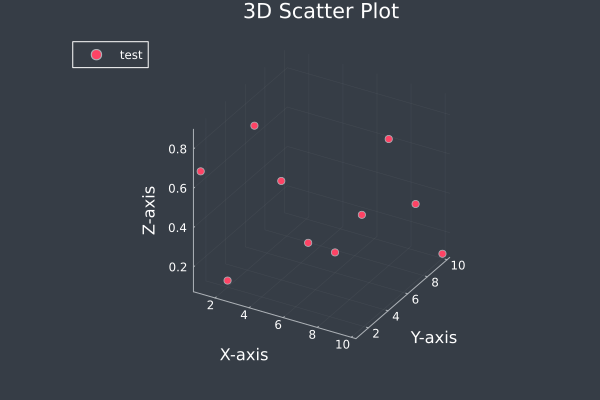

In [49]:
x = 1:10
y = 1:10
z = rand(10)
theme(:dark)
s = scatter3d(x, y, z, title = "3D Scatter Plot", xlabel = "X-axis", ylabel = "Y-axis", zlabel = "Z-axis", label="test")


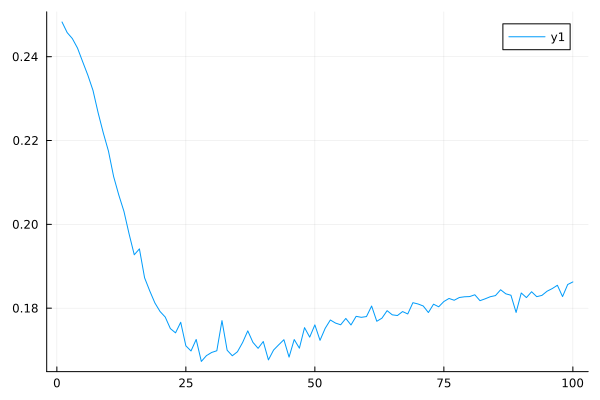

In [33]:
function getPlot(x, y)
    p = plot(x, y)
    return p
end

getPlot(1:size(performance["loss"][1:100], 1), performance["loss"][1:100])

In [157]:
# Define the encoder
function getEncoder()
    encoder = Chain(
        Dense(size(trainX, 2), 64, relu),
        Dense(64, 32, relu),
        Dense(32, 6, σ)
    )
    return encoder
end

# Define the decoder
function getDecoder()
    decoder = Chain(
        Dense(6, 32, σ),
        Dense(32, 64, relu),
        Dense(64, size(trainX, 2))
    )
end
# Combine into an autoencoder
function getAutoEncoder()
    autoencoder = Chain(getEncoder(), getDecoder())
    return autoencoder
end
# Optimizer
optimizer = ADAM(0.001)
epochs = 500

function autoencoder_loss(x, model)
    reconstruction = model(x)
    return Flux.mse(reconstruction, x)
end


autoencoder_loss (generic function with 1 method)

In [158]:
opt = ADAM(0.001)
params = Flux.params(autoencoder)
epochs = 2500

trainLosses, testLosses = [], []
for epoch in 1:epochs
    trainloss, testloss, numbatches = 0.0, 0.0, 0
    for (x, y) in train_data
        grads = Flux.gradient(params) do
            loss = autoencoder_loss(x, autoencoder)
            return loss
        end
        Flux.Optimise.update!(opt, params, grads)
        trainloss += autoencoder_loss(x, autoencoder)
        numbatches += 1
    end
    trainloss /= numbatches
    push!(trainLosses, trainloss)

    numbatches = 0
    for (x, y) in test_data
        testloss += autoencoder_loss(x, autoencoder)
        numbatches += 1
    end
    testloss /= numbatches
    push!(testLosses, testloss)

end


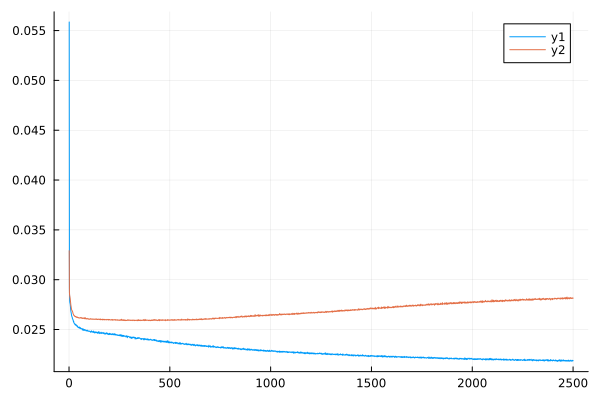

In [159]:
plot(1:epochs, [trainLosses, testLosses])

In [160]:
train_data = DataLoader((trainX', trainYCold'), batchsize=batch_size, shuffle=true)
test_data = DataLoader((testX', testYCold'), batchsize=batch_size)

function getClassifier()
    classifier = Chain(
        encoder,
        Dense(6, 2, relu),
        Dense(2, 1, σ)
        # Dense(4, 1, σ) # Output a single logit for binary classification
        # # σ # Use sigmoid for binary classification
    )
    return classifier
end

epochs = 10000
opt = ADAM(0.001)

# Use binary crossentropy loss for binary classification
loss(x, y) = Flux.mse(classifier(x), y)

# For binary classification, accuracy is calculated by thresholding at 0.5
function accuracy(x, y, model) 
    confusionmatrix = getConfusionMatrix(x, y, model)
    acc = (confusionmatrix[1, 1] + confusionmatrix[2, 2]) / sum(confusionmatrix)
    return acc
end

function getConfusionMatrix(x, y, model)
    tPos, tNeg, fPos, fNeg = 0, 0, 0, 0
    # println(size(x))
    # println(size(y))
    # println(size(x[1]))
    for i in 1:size(x, 2)
        prediction = model(x[:, i])[1]
        if prediction >= 0.5 && y[i] == 1
            tPos += 1
        elseif prediction < 0.5 && y[i] == 0
            fNeg += 1
        elseif prediction >= 0.5 && y[i] == 0
            fPos += 1
        elseif prediction < 0.5 && y[i] == 1
            tNeg += 1
        else
            error("Debug")
        end
    end
    return [tPos tNeg;fPos fNeg]
end
        
classifierTestLosses, classifierTestAccuracies = [], []
for epoch in 1:epochs
    for (x, y) in train_data
        grads = Flux.gradient(Flux.params(classifier)) do
            loss(x, y)
        end
        Flux.Optimise.update!(opt, Flux.params(classifier), grads)
    end

    testloss = loss(testX', testYCold')
    testaccuracy = accuracy(testX',testYCold', classifier)
    push!(classifierTestLosses, testloss)
    push!(classifierTestAccuracies, testaccuracy)
end


In [155]:
train_data

24-element DataLoader(::Tuple{Adjoint{Float64, Matrix{Float64}}, Adjoint{Float64, Vector{Float64}}}, shuffle=true, batchsize=64)
  with first element:
  (20×64 Matrix{Float64}, 1×64 adjoint(::Vector{Float64}) with eltype Float64,)

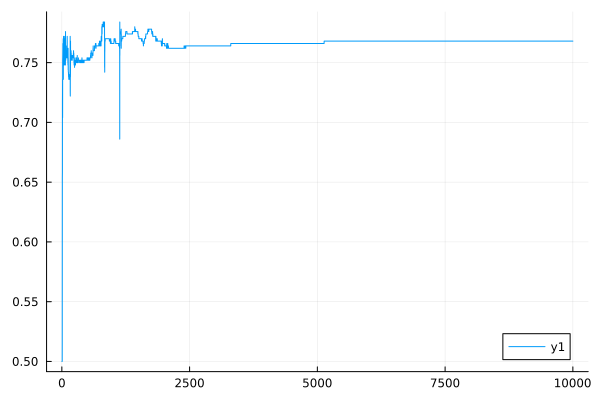

In [161]:
plot(1:epochs, classifierTestAccuracies)

In [58]:
argmax(classifierTestAccuracies)

UndefVarError: UndefVarError: classifierTestAccuracies not defined

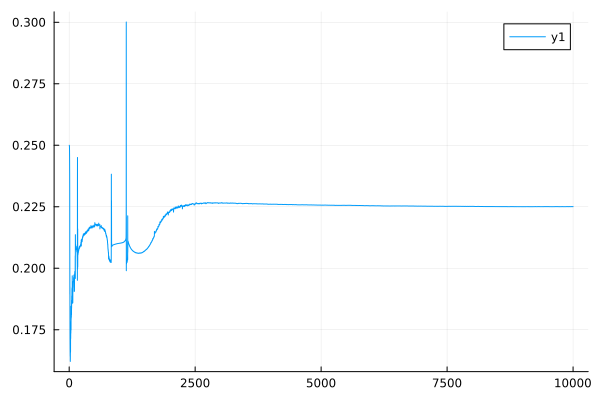

In [162]:
plot(1:epochs, classifierTestLosses)

In [71]:
(classifier(testX[1, :]))

2-element Vector{Float32}:
 0.41652644
 0.58347356

In [70]:
Flux.onecold(testY[1:5])

2

In [72]:
testY[1]

false

In [76]:
accuracy(trainX', trainY')

0.003

In [26]:
loss(trainX', trainYCold')

0.6081483698313435

In [36]:
classifier(trainX[1, :])

1-element Vector{Float32}:
 0.5

In [34]:
trainY[1]

false

In [66]:
loss(testX', testYCold')

0.8342522473875433

In [67]:
accuracy(testX', testYCold')

0.472

In [68]:
mean((classifier(testX') .> 0.5) .== testYCold')

0.472

In [79]:
count(x -> x == 1, (classifier(testX') .> 0.5) .== testYCold') / size(testX, 1)

0.472

In [70]:
testYCold'

1×500 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  …  0.0  0.0  1.0  1.0  0.0  0.0  0.0

In [137]:
classifierTestLosses

10000-element Vector{Any}:
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 ⋮
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498
 0.8165009245872498

In [55]:
x = [1, 2, 3]

a, b, c = (x...)

ErrorException: syntax: "..." expression outside call around /Users/advaitshukla/Documents/ANN/autoEncoder.ipynb:3

In [57]:
size([1 2 3], 2)

3